In [12]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import os
from os.path import join as opj
import sys
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

# Simple fix for smplx numpy compatibility in recent numpy versions.
np.bool = np.bool_
np.int = np.int_
np.float = np.float_
np.complex = np.complex_
np.object = np.object_
np.unicode = np.unicode_
np.str = np.str_

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.gridspec import GridSpec

import seaborn as sns

from IPython.display import HTML, display, Video

from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
from scipy.interpolate import interp1d

from smplx.body_models import SMPL, SMPLH

os.environ['PYOPENGL_PLATFORM'] = 'egl'

from musint.benchmarks.muscle_sets import MIA_MUSCLES
from musint.benchmarks.muscle_sets import MUSCLE_SUBSETS

import mia_utils as miau
import amass_utils as amau
from plotting_utils import visualize_pose, plot_emg_data

plt.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "serif",
        "font.serif": ["DejaVu Serif"],
        "font.sans-serif": ["Helvetica"],
        "figure.figsize": (6, 4.8),  # Figure size
        "font.size": 12,  # Global font size
        "axes.titlesize": 12,  # Title font size
        "axes.labelsize": 12,  # Axes labels font size
        "xtick.labelsize": 12,  # X-tick labels font size
        "ytick.labelsize": 12,  # Y-tick labels font size
        "legend.fontsize": 12,  # Legend font size
        "figure.titlesize": 12,  # Figure title font size
    }
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
amass_root = "notebook_resources/amass_root"
preds_root = "notebook_resources/mint_predictions"

m_bm_path = "./body_models/smplh/male/model.npz"
m_dmpl_path = "./body_models/dmpls/male/model.npz"

f_bm_path = "./body_models/smplh/female/model.npz"
f_dmpl_path = "./body_models/dmpls/female/model.npz"

In [14]:
from body_models.body_model import BodyModel

num_betas = 10  # number of body parameters
num_dmpls = 8  # number of DMPL parameters

male_bm = BodyModel(bm_fname=m_bm_path, num_betas=num_betas, num_dmpls=num_dmpls, dmpl_fname=m_dmpl_path).cuda()
faces = male_bm.f if isinstance(male_bm.f, np.ndarray) else male_bm.f.detach().cpu().numpy()

female_bm = BodyModel(bm_fname=f_bm_path, num_betas=num_betas, num_dmpls=num_dmpls, dmpl_fname=f_dmpl_path).cuda()

In [15]:
# This metadata was generated with the predictions. ids are subject/action pairs (rub029/0021_catching_and_throwing), but predictions are 1.4 second segments, so ids are not unique.
mint_pred_meta = pd.read_csv(opj(preds_root, "metadata.csv"))

# This resolves where to find amass motions within amass_root for each motion. Required to display the mesh nodes.
path_mappings = pd.read_csv(opj(amass_root, "path_mappings.csv"))

mint_pred_meta = mint_pred_meta.merge(path_mappings, left_on="name", right_on="id", how="inner")
mint_pred_meta.set_index("name", inplace=True)

In [16]:
path_mappings

,path,id
0,./TotalCapture/TotalCapture/s3/rom3_poses.npz,s3/rom3
1,./TotalCapture/TotalCapture/s3/rom2_poses.npz,s3/rom2
2,./TotalCapture/TotalCapture/s3/acting2_poses.npz,s3/acting2
3,./TotalCapture/TotalCapture/s3/rom1_poses.npz,s3/rom1
4,./TotalCapture/TotalCapture/s3/walking1_poses.npz,s3/walking1
...,...,...
12441,./BMLmovi/BMLmovi/Subject_34_F_MoSh/Subject_34...,Subject_34_F_MoSh/Subject_34_F_18
12442,./BMLmovi/BMLmovi/Subject_34_F_MoSh/Subject_34...,Subject_34_F_MoSh/Subject_34_F_6
12443,./BMLmovi/BMLmovi/Subject_34_F_MoSh/Subject_34...,Subject_34_F_MoSh/Subject_34_F_19
12444,./BMLmovi/BMLmovi/Subject_34_F_MoSh/Subject_34...,Subject_34_F_MoSh/Subject_34_F_4


In [17]:
mint_pred_meta

,gt_name,pred_name,time_start,path,id
name,,,,,
rub029/0021_catching_and_throwing,rub029__I__0021_catching_and_throwing_0_gt.npy,rub029__I__0021_catching_and_throwing_0_pred.npy,1.4,./BMLrub/BioMotionLab_NTroje/rub029/0021_catch...,rub029/0021_catching_and_throwing
rub029/0021_catching_and_throwing,rub029__I__0021_catching_and_throwing_1_gt.npy,rub029__I__0021_catching_and_throwing_1_pred.npy,2.8,./BMLrub/BioMotionLab_NTroje/rub029/0021_catch...,rub029/0021_catching_and_throwing
rub029/0021_catching_and_throwing,rub029__I__0021_catching_and_throwing_2_gt.npy,rub029__I__0021_catching_and_throwing_2_pred.npy,4.2,./BMLrub/BioMotionLab_NTroje/rub029/0021_catch...,rub029/0021_catching_and_throwing
rub029/0021_catching_and_throwing,rub029__I__0021_catching_and_throwing_3_gt.npy,rub029__I__0021_catching_and_throwing_3_pred.npy,5.6,./BMLrub/BioMotionLab_NTroje/rub029/0021_catch...,rub029/0021_catching_and_throwing
rub029/0021_catching_and_throwing,rub029__I__0021_catching_and_throwing_4_gt.npy,rub029__I__0021_catching_and_throwing_4_pred.npy,7.0,./BMLrub/BioMotionLab_NTroje/rub029/0021_catch...,rub029/0021_catching_and_throwing
...,...,...,...,...,...
Subject_71_F_MoSh/Subject_71_F_2,Subject_71_F_MoSh__I__Subject_71_F_2_601_gt.npy,Subject_71_F_MoSh__I__Subject_71_F_2_601_pred.npy,2.8,./BMLmovi/BMLmovi/Subject_71_F_MoSh/Subject_71...,Subject_71_F_MoSh/Subject_71_F_2
Subject_71_F_MoSh/Subject_71_F_2,Subject_71_F_MoSh__I__Subject_71_F_2_602_gt.npy,Subject_71_F_MoSh__I__Subject_71_F_2_602_pred.npy,4.2,./BMLmovi/BMLmovi/Subject_71_F_MoSh/Subject_71...,Subject_71_F_MoSh/Subject_71_F_2
Subject_71_F_MoSh/Subject_71_F_2,Subject_71_F_MoSh__I__Subject_71_F_2_603_gt.npy,Subject_71_F_MoSh__I__Subject_71_F_2_603_pred.npy,5.6,./BMLmovi/BMLmovi/Subject_71_F_MoSh/Subject_71...,Subject_71_F_MoSh/Subject_71_F_2


  0%|          | 0/100 [00:00<?, ?it/s]

317/turn_left08


  1%|          | 1/100 [00:11<18:50, 11.42s/it]

rub066/0030_rom


  2%|▏         | 2/100 [00:22<18:38, 11.41s/it]

7/WalkInClockwiseCircle04


  2%|▏         | 2/100 [00:30<24:45, 15.16s/it]


KeyboardInterrupt: 

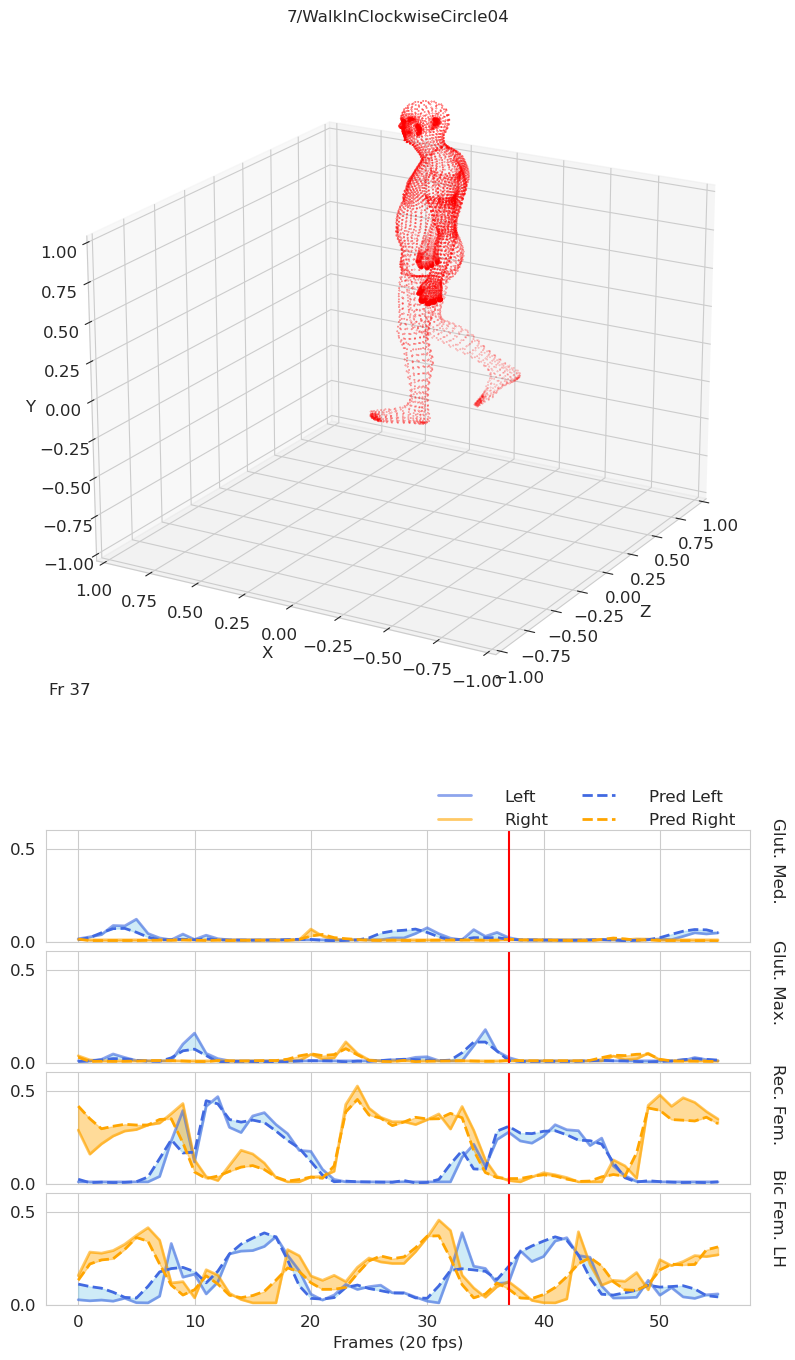

In [21]:
random.seed(42)

# Mapping of muscle identifiers to their full names
muscle_idxs = [
    i for i, mus in enumerate(MUSCLE_SUBSETS["MUSINT_402"]) if mus in MUSCLE_SUBSETS["LAI_ARNOLD_LOWER_BODY_8"]
]

full_muscle_names = [
    "Glut. Med. (L)",
    "Glut. Max. (L)",
    "Rec. Fem. (L)",
    "Bic Fem. LH (L)",
    "Glut. Med. (R)",
    "Glut. Max. (R)",
    "Rec. Fem. (R)",
    "Bic Fem. LH (R)",
]

animations = []

random_sample = mint_pred_meta.sample(n=100)

for i in tqdm(range(min(100, len(random_sample)))):
    # Setting up the following visualization. Selecting a random sample with that activity.
    # activity = "LegBack"

    # idx = random.randint(0, len(mint_pred_meta))
    sample = random_sample.iloc[i]

    print(sample["id"])

    body = amau.amass_to_smpl(opj(amass_root, sample["path"]), male_bm, female_bm, num_betas)

    vertices = body.v.detach().cpu().numpy()

    trans_matrix = np.array([[-1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    vertices = np.dot(vertices, trans_matrix)

    gts, preds, start, end = miau.load_and_concat_mia_dat(sample["id"], mint_pred_meta, preds_root)

    if gts is None:
        continue

    gts, preds = gts[..., muscle_idxs], preds[..., muscle_idxs]

    num_frames = min(len(vertices), 240, end)
    vertices = vertices[start:num_frames]

    gts, preds = gts[start:num_frames], preds[start:num_frames]

    fig = plt.figure(figsize=(8, 14))

    gs = GridSpec(2, 1, height_ratios=[5, 3])

    ax = fig.add_subplot(gs[0], projection="3d")

    lines = plot_emg_data(gts, preds, full_muscle_names, fig=fig, gridspec=gs, ylim=(0, 0.6), show_pred=True)

    def update(frame):
        ax.clear()
        visualize_pose(vertices[frame], frame, ax, title=sample["id"])

        for line in lines:
            line.set_xdata([frame])

        return [ax, lines]

    plt.tight_layout()

    ani = FuncAnimation(fig, update, frames=len(vertices), interval=50)  # 20 fps = 50ms interval

    path_id = sample["id"].replace("/", "__I__")

    ani.save(f"notebook_output/mint/{path_id}.mp4", writer="ffmpeg", fps=20)
    display(Video(f"notebook_output/mint/{path_id}.mp4", embed=True))

    plt.close(fig)  # Prevents the static plot from showing